In [35]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
#csv_data = pd.read_csv('IF888.csv')  # 读取数据
csv_data = pd.read_csv('SLM_DATA_IF.csv')  # 读取数据

In [36]:
#预测指标（涨跌），基于每日交易
csv_data["updown"] = 1
day = 1
for i in range(day,len(csv_data)):
    if(csv_data.loc[i,"CLOSE"]-csv_data.loc[i-day,"CLOSE"]>=0):
        csv_data.loc[i-day,"updown"]=1
    else:
        csv_data.loc[i-day,"updown"]=-1
        
csv_data["zhangdie"] = 0
for i in range(day,len(csv_data)):
    csv_data.loc[i-day,"zhangdie"]=csv_data.loc[i,"CLOSE"]-csv_data.loc[i-day,"CLOSE"]

In [37]:
#设定参数
N = 400
dailyprofitlv = 0
profit = [0 for x in range(len(csv_data)-N-1)]
sharpup = [0 for x in range(len(csv_data)-N-1)]

In [38]:
#因子库
# 开盘缺口
csv_data["closeopen"]=(csv_data["OPEN"]/csv_data["CLOSE"]-1)*10
# Alpha#101
csv_data["highlow"]=(csv_data["CLOSE"]-csv_data["OPEN"])/(csv_data["HIGH"]-csv_data["LOW"]+0.001)
# change of settlement
#csv_data["settlementchange"]=(csv_data["HIGH"].values+csv_data["LOW"].values)/(csv_data['OPEN'].values+csv_data['CLOSE'].values)
#12daysdelay
csv_data['12close'] = [0 for x in range(len(csv_data))]
for i in range(12,len(csv_data)):
    csv_data.loc[i,'12close'] = (csv_data.loc[i,'CLOSE']/csv_data.loc[i-12,'CLOSE']-1)*10
#12daysmax
csv_data['12max'] = [0 for x in range(len(csv_data))]
for i in range(12,len(csv_data)):
    csv_data.loc[i,'12max']=csv_data.loc[i,'CLOSE']/np.max(csv_data.loc[i-12:i,'CLOSE'])-1
#6daysdelay
csv_data['6close'] = [0 for x in range(len(csv_data))]
for i in range(6,len(csv_data)):
    csv_data.loc[i,'6close'] = (csv_data.loc[i,'CLOSE']/csv_data.loc[i-6,'CLOSE']-1)*10
#6daysmax
csv_data['6max'] = [0 for x in range(len(csv_data))]
for i in range(6,len(csv_data)):
    csv_data.loc[i,"6max"]=csv_data.loc[i,'CLOSE']/np.max(csv_data.loc[i-6:i,'CLOSE'])-1
#30mean
csv_data["30mean"] = [0 for x in range(len(csv_data))]
for i in range(30,len(csv_data)):
    csv_data.loc[i,"30mean"] = (csv_data.loc[i,'CLOSE']/np.mean(csv_data.loc[i-30:i,'CLOSE'])-1)*10
#10mean
csv_data["10mean"] = [0 for x in range(len(csv_data))]
for i in range(10,len(csv_data)):
    csv_data.loc[i,"10mean"] = (csv_data.loc[i,'CLOSE']/np.mean(csv_data.loc[i-10:i,'CLOSE'])-1)*10
#1dayvolumechange
csv_data['volumech'] = [0 for x in range(len(csv_data))]
for i in range(12,len(csv_data)):
    csv_data.loc[i,'volumech'] = csv_data.loc[i,'VOLUME']/csv_data.loc[i-1,'VOLUME']-1

In [18]:
csv_data[30:]

,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME,updown,zhangdie,closeopen,highlow,12close,12max,6close,6max,30mean,10mean,volumech
30,2010/6/21,2735.127396,2802.182388,2704.087102,2790.442790,277989,-1,-7.163144,-0.198232,0.563889,-0.024705,-0.002471,0.222810,-0.001326,-0.101910,0.121417,0.112041
31,2010/6/22,2781.289883,2800.590579,2778.902168,2783.279646,220831,-1,-32.234151,-0.007149,0.091739,0.057758,-0.003890,-0.038896,-0.003890,-0.094095,0.094917,-0.205612
32,2010/6/23,2770.744143,2787.259170,2728.959132,2751.045495,238316,1,5.770311,0.071604,-0.337878,-0.110285,-0.015426,-0.086004,-0.014119,-0.184437,-0.021264,0.079178
33,2010/6/24,2756.815806,2795.616173,2735.923301,2756.815806,297949,-1,-17.111957,0.000000,0.000000,0.012881,-0.013361,-0.051560,-0.012051,-0.147885,0.002793,0.250227
34,2010/6/25,2744.877231,2758.606592,2721.994964,2739.703849,249654,-1,-12.137551,0.018883,-0.141300,-0.096123,-0.019485,-0.035492,-0.018183,-0.188873,-0.068572,-0.162091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,2019/9/18,4770.710760,4793.443563,4764.844231,4771.688515,55124,1,25.421629,-0.002049,0.034187,0.296429,-0.018256,-0.161282,-0.018256,0.285874,-0.057921,-0.292102
2282,2019/9/19,4786.843717,4797.110144,4758.244385,4797.110144,44195,1,2.199003,-0.021401,0.264144,0.241090,-0.013026,-0.089885,-0.013026,0.313796,-0.025736,-0.198262
2283,2019/9/20,4803.954428,4815.200899,4790.507561,4799.309147,59557,-1,-38.140205,0.009679,-0.188111,0.239372,-0.012573,-0.017796,-0.012573,0.289222,-0.030100,0.347596
2284,2019/9/23,4782.439441,4783.417395,4727.918506,4761.168942,70709,-1,-0.244489,0.044675,-0.383253,0.019529,-0.020420,-0.204202,-0.020420,0.184706,-0.102933,0.187249


In [ ]:
#模型参数优化
from sklearn.model_selection import GridSearchCV
data = []
data=pd.DataFrame(data)
target = []
target=pd.DataFrame(target)
data["closeopen"] = csv_data["closeopen"].loc[100:1000]
data["highlow"] = csv_data["highlow"].loc[100:1000]
data["12close"] = csv_data["12close"].loc[100:1000]
data['12max'] = csv_data['12max'].loc[100:1000]
data['6max'] = csv_data['6max'].loc[100:1000]
data["6close"] = csv_data["6close"].loc[100:1000]
data['30mean'] = csv_data['30mean'].loc[100:1000]
data['10mean'] = csv_data['10mean'].loc[100:1000]
data['volumech'] = csv_data['volumech'].loc[100:1000]
target = csv_data["updown"].loc[100:1000]
#target = csv_data["zhangdie"].loc[i:i+N]
data = data.values
target = target.values
train = data[:-1]
t_train = target[:-1]
param_grid = {"n_estimators":range(10,200,10),"random_state":range(10)}
gsearch = GridSearchCV(estimator=RandomForestClassifier(),param_grid=param_grid,scoring="roc_auc",cv=3)
gsearch.fit(train,t_train)
print(gsearch.best_params_)
print(gsearch.best_score_)

In [39]:
#开始循环(滚动预测)
#print('交易日志:')
for i in range(30,len(csv_data)-N-1):
    data = []
    data=pd.DataFrame(data)
    target = []
    target=pd.DataFrame(target)
    
    #取训练集和测试集
    data["closeopen"] = csv_data["closeopen"].loc[i:i+N]
    data["highlow"] = csv_data["highlow"].loc[i:i+N]
    data["12close"] = csv_data["12close"].loc[i:i+N]
    data['12max'] = csv_data['12max'].loc[i:i+N]
    data['6max'] = csv_data['6max'].loc[i:i+N]
    data["6close"] = csv_data["6close"].loc[i:i+N]
    data['30mean'] = csv_data['30mean'].loc[i:i+N]
    data['10mean'] = csv_data['10mean'].loc[i:i+N]
    data['volumech'] = csv_data['volumech'].loc[i:i+N]
    target = csv_data["updown"].loc[i:i+N]
    #target = csv_data["zhangdie"].loc[i:i+N]
    
    
    #对数据集简单处理
    data = data.values
    target = target.values
    train = data[:-1]
    t_train = target[:-1]
    test = data[-1].reshape(1, -1)
    
    #随机森林模型进行预测
    model = RandomForestClassifier(n_estimators=10,random_state=7)
    #model = RandomForestRegressor(n_estimators=100,random_state=0)
    model.fit(train,t_train)
    predicted = model.predict(test)
    predicted = predicted[0]
    t_test = target[-1].reshape(1, -1)
    t_test = t_test[0][0]
    print(model.feature_importances_)
#     print(predicted)
#     print(t_test)
    price = csv_data.loc[i+N,'CLOSE']
    tomorrow_price = csv_data.loc[i+N+1,'CLOSE']
    #print(tomorrow_price-price)
    #print(tomorrow_price)
    if(predicted>0):
        signal = -1
        dailyprofitlv = tomorrow_price/price-1
        profit[i]=profit[i-1]+signal*dailyprofitlv
        sharpup[i] = signal*dailyprofitlv
    else:
        signal = 1
        dailyprofitlv = tomorrow_price/price-1
        profit[i]=profit[i-1]+signal*dailyprofitlv
        sharpup[i] = signal*dailyprofitlv

[0.13817649 0.09575453 0.12370803 0.0793675  0.1007629  0.08746858
 0.11157538 0.13575655 0.12743004]
[0.11670118 0.1337062  0.13455608 0.08315705 0.09461439 0.0921883
 0.11088055 0.116075   0.11812124]
[0.09347835 0.13332786 0.11953216 0.08269131 0.12942271 0.07472456
 0.12761857 0.12349309 0.11571139]
[0.09708923 0.09618446 0.12890301 0.11768979 0.11466997 0.11881374
 0.11744289 0.10274219 0.10646473]
[0.11167809 0.11868233 0.13693411 0.08183738 0.08673835 0.08793361
 0.13315948 0.11503062 0.12800603]
[0.10742815 0.10110766 0.13500527 0.08889497 0.09628517 0.1160138
 0.12209166 0.12735674 0.10581658]
[0.11259268 0.10937037 0.14336211 0.09095047 0.11214038 0.10256665
 0.10882579 0.11958074 0.1006108 ]
[0.08759628 0.10886556 0.13722933 0.07831176 0.10776274 0.12763658
 0.12613589 0.12250505 0.10395682]
[0.12621932 0.07849395 0.14536435 0.09108007 0.09374021 0.11210219
 0.09774666 0.13945518 0.11579809]
[0.14177768 0.12930962 0.13722154 0.09521326 0.07247374 0.09604064
 0.12352704 0.092

 0.1184935  0.12441097 0.09252091]
[0.10923176 0.09142699 0.12924689 0.10874254 0.0947681  0.11774675
 0.13083602 0.12673845 0.09126248]
[0.11564369 0.107027   0.10960497 0.12201564 0.10742398 0.10175546
 0.11136716 0.11956319 0.10559891]
[0.1286576  0.1003441  0.11164462 0.11514928 0.10728056 0.10430296
 0.12124303 0.09850294 0.11287489]
[0.13023961 0.11522248 0.13330971 0.09390149 0.10291299 0.09862088
 0.10583638 0.11335954 0.10659691]
[0.1188322  0.11972366 0.14291166 0.08210504 0.11432212 0.1122938
 0.1007238  0.11156733 0.09752038]
[0.10497579 0.106905   0.14199913 0.09853087 0.1147444  0.09307032
 0.13268858 0.09416626 0.11291964]
[0.11684141 0.12181328 0.12683922 0.09377528 0.12490869 0.09433505
 0.13140071 0.1115297  0.07855665]
[0.09982418 0.1103625  0.11967949 0.10368265 0.1068667  0.12297107
 0.11714541 0.13512511 0.08434289]
[0.13832867 0.09919118 0.13626859 0.08539925 0.0940443  0.1180947
 0.11034258 0.1282605  0.09007022]
[0.12450115 0.11978057 0.12363088 0.09087523 0.10

 0.12231854 0.12455956 0.08497762]
[0.11958539 0.11184801 0.10240053 0.11577812 0.08805658 0.10194119
 0.13094059 0.13807655 0.09137302]
[0.12703821 0.09288256 0.08627984 0.07779265 0.11069651 0.11859362
 0.11923796 0.15145956 0.11601911]
[0.09911927 0.1094636  0.11984629 0.11403531 0.1157017  0.11618098
 0.10742218 0.12363078 0.0945999 ]
[0.10435549 0.1102878  0.10805886 0.07962181 0.11682728 0.13164577
 0.1041377  0.14754914 0.09751613]
[0.11866174 0.10030289 0.09203754 0.10775132 0.12624911 0.11900235
 0.12013103 0.11677933 0.09908469]
[0.13251945 0.09852192 0.12206782 0.08783181 0.12621367 0.10748999
 0.09482432 0.1398806  0.09065042]
[0.11607359 0.10447759 0.11620937 0.0874335  0.13122095 0.11384388
 0.10803399 0.12823723 0.0944699 ]
[0.11804215 0.10802167 0.13708835 0.0832442  0.09256387 0.12512072
 0.11973588 0.12958362 0.08659954]
[0.10841485 0.11013859 0.11647134 0.0881002  0.10079808 0.13573428
 0.11241714 0.14362048 0.08430503]
[0.12106698 0.10155461 0.11524416 0.08094491 0.

 0.09710834 0.13933931 0.11715973]
[0.11242257 0.12163982 0.09565705 0.0865332  0.08215351 0.1329199
 0.10856146 0.16363955 0.09647295]
[0.1127708  0.11894702 0.12024338 0.07209478 0.10125923 0.15671858
 0.09637307 0.11355765 0.10803549]
[0.13385962 0.10122539 0.13449424 0.09018132 0.09790229 0.09810022
 0.12220822 0.12876125 0.09326746]
[0.10451591 0.11502731 0.11896993 0.10859514 0.08689545 0.09169694
 0.12209882 0.15483124 0.09736925]
[0.12481652 0.10904931 0.10933023 0.08387653 0.10190428 0.11039846
 0.1097979  0.12761316 0.12321361]
[0.1105989  0.10834073 0.13312569 0.08450385 0.10093171 0.10445175
 0.11163084 0.1301229  0.11629363]
[0.12330444 0.11581449 0.1062429  0.08623383 0.1086401  0.10985634
 0.10063941 0.14482972 0.10443876]
[0.11146847 0.11079447 0.11799083 0.0951543  0.09931703 0.11146676
 0.14050867 0.13071902 0.08258044]
[0.15153994 0.10367049 0.11268253 0.07827358 0.09898749 0.12178377
 0.12191152 0.12164611 0.08950456]
[0.11855481 0.1076515  0.1199809  0.1090635  0.1

 0.13788981 0.12507497 0.09266728]
[0.13316248 0.09953501 0.13415887 0.09338151 0.07940255 0.10471746
 0.11919942 0.11582506 0.12061763]
[0.10655546 0.11213233 0.13260239 0.07121994 0.07899963 0.10071224
 0.1225528  0.14070685 0.13451837]
[0.12085848 0.10779956 0.12195346 0.08323586 0.09303005 0.1061691
 0.1274086  0.12813951 0.11140538]
[0.11655526 0.10639025 0.11879127 0.07826722 0.09170543 0.09820891
 0.13220279 0.13728074 0.12059812]
[0.11565247 0.12130588 0.14433993 0.08214381 0.08599331 0.11620837
 0.11258586 0.11412375 0.10764663]
[0.1219587  0.11560508 0.13268202 0.08275052 0.08406228 0.11717679
 0.11044365 0.13231257 0.1030084 ]
[0.11775861 0.12414577 0.12375315 0.07689191 0.08349413 0.12360004
 0.13728248 0.10559285 0.10748106]
[0.13410711 0.09967436 0.12677114 0.08819481 0.08970042 0.09862845
 0.10819511 0.1537772  0.10095139]
[0.11830994 0.10343233 0.12925508 0.07697913 0.08922385 0.10911081
 0.13721825 0.12220973 0.11426089]
[0.13361204 0.11310852 0.1061221  0.09290274 0.0

[0.12423386 0.09019101 0.12095363 0.06485337 0.08583008 0.12122538
 0.12935629 0.13611065 0.12724574]
[0.11833426 0.10464573 0.12112363 0.0704656  0.0862676  0.13440878
 0.13527824 0.10898416 0.12049201]
[0.13513697 0.09331826 0.13854973 0.09600577 0.07481425 0.10213925
 0.11994373 0.13946682 0.10062521]
[0.11671361 0.09485426 0.10157897 0.09743934 0.08885968 0.11521248
 0.13869779 0.14078527 0.10585859]
[0.11441717 0.10617278 0.12620424 0.08902049 0.09605807 0.10136261
 0.13666202 0.13698369 0.09311894]
[0.11369474 0.0967009  0.13705357 0.08643085 0.09432263 0.13528411
 0.12027557 0.12023841 0.09599921]
[0.11932027 0.12419871 0.10306376 0.0851029  0.08550343 0.12249266
 0.13342681 0.13180795 0.0950835 ]
[0.1349206  0.12299926 0.08217713 0.07717513 0.09447478 0.09529156
 0.14332391 0.13740072 0.11223691]
[0.12584434 0.11419004 0.12146928 0.09976123 0.09042515 0.10366383
 0.11589652 0.12188264 0.10686696]
[0.11623234 0.11421258 0.12109514 0.09017446 0.10205061 0.10433009
 0.10205515 0.1

[0.12642051 0.11442704 0.10292576 0.08501484 0.1026076  0.1220044
 0.09975152 0.13191961 0.11492873]
[0.12590492 0.13610626 0.08818927 0.09356849 0.0704399  0.11898889
 0.10662591 0.14851644 0.11165992]
[0.09865387 0.09311557 0.10394422 0.11746031 0.09728323 0.10905781
 0.11755805 0.14884432 0.11408263]
[0.10888693 0.12274394 0.11623581 0.073044   0.08916916 0.10364114
 0.11581377 0.12799703 0.14246823]
[0.12038135 0.09400043 0.11658839 0.11389025 0.10516521 0.11144946
 0.11856889 0.11327082 0.1066852 ]
[0.10044304 0.12593489 0.11925333 0.09180369 0.07193416 0.11868816
 0.12599174 0.13109719 0.1148538 ]
[0.12149603 0.10784469 0.12205194 0.08839184 0.07207749 0.11126739
 0.12916031 0.13002832 0.11768199]
[0.13464925 0.11405353 0.10453002 0.08942438 0.08435629 0.09903034
 0.12110339 0.12679647 0.12605633]
[0.11649811 0.12719215 0.11934237 0.08607159 0.07223696 0.12151062
 0.12976937 0.11441797 0.11296085]
[0.12856639 0.09650779 0.10900125 0.10175334 0.09468231 0.11481448
 0.1025843  0.11

[0.12147947 0.11084125 0.12651519 0.10041371 0.07746004 0.11439482
 0.1132799  0.12896764 0.10664799]
[0.11449339 0.1026823  0.1145282  0.09304874 0.08519288 0.13733389
 0.10575633 0.12578851 0.12117575]
[0.09793932 0.12639544 0.12754149 0.11154768 0.07831731 0.12557104
 0.105146   0.09688799 0.13065373]
[0.12036961 0.08808392 0.11812169 0.08104643 0.09612322 0.13860443
 0.12243031 0.12071183 0.11450856]
[0.1254159  0.09049551 0.12745131 0.10768993 0.08580145 0.11388446
 0.10505813 0.12231615 0.12188716]
[0.1228933  0.1249802  0.1474551  0.08488963 0.08411726 0.11671763
 0.10117909 0.11783392 0.09993387]
[0.12270645 0.1182788  0.11318256 0.11473012 0.07672206 0.09927486
 0.12828462 0.1192405  0.10758002]
[0.11297449 0.10668986 0.13468739 0.08444517 0.07913053 0.14305106
 0.10660695 0.12402429 0.10839026]
[0.12503485 0.12401234 0.1165898  0.08165339 0.07253773 0.13791947
 0.10634339 0.12811272 0.10779633]
[0.13480245 0.11741063 0.11197679 0.09369955 0.07875064 0.1246685
 0.12049661 0.10

 0.1055971  0.13565916 0.12768249]
[0.10954138 0.10463996 0.1457568  0.096458   0.07244367 0.11645914
 0.13463898 0.09787831 0.12218375]
[0.11313964 0.10121729 0.122702   0.09419902 0.10032589 0.10257853
 0.11697778 0.11693905 0.13192079]
[0.11176318 0.10526948 0.12463761 0.10838932 0.07246093 0.0990245
 0.10110271 0.14975952 0.12759274]
[0.10842433 0.11436579 0.11227443 0.08880073 0.07943384 0.10875662
 0.13234502 0.14509814 0.11050111]
[0.11635864 0.1277056  0.09123532 0.10389884 0.09256201 0.10724704
 0.10902357 0.12661136 0.12535761]
[0.11885587 0.11882897 0.13816687 0.08607536 0.08843297 0.10574294
 0.11157597 0.13159877 0.10072229]
[0.13190294 0.11724615 0.11627143 0.08706142 0.06122659 0.10171418
 0.10741608 0.12633116 0.15083006]
[0.09826039 0.12368289 0.10880592 0.09913502 0.09086375 0.09549552
 0.1328783  0.11839789 0.13248032]
[0.10898774 0.11510812 0.11605419 0.10229559 0.08352591 0.12022107
 0.12708648 0.10580823 0.12091267]
[0.13049231 0.10520288 0.13402495 0.07237115 0.0

 0.12263359 0.13180479 0.12302207]
[0.11024112 0.11166221 0.12575714 0.09377055 0.07678096 0.10349444
 0.11755549 0.11733233 0.14340577]
[0.09210923 0.11239765 0.12141742 0.07892122 0.07484667 0.10733873
 0.14661788 0.12696085 0.13939034]
[0.08841591 0.13839647 0.12522107 0.08310267 0.08198731 0.1178956
 0.12810354 0.12188122 0.11499622]
[0.11146707 0.10925258 0.11843852 0.08939891 0.09569979 0.09636454
 0.14330114 0.12222655 0.11385091]
[0.11643504 0.12595215 0.13322332 0.09022005 0.10587682 0.09993631
 0.11082986 0.10869395 0.10883251]
[0.1172763  0.10347538 0.12442047 0.08862444 0.07901466 0.1213129
 0.13052457 0.1307049  0.10464637]
[0.11462136 0.09170688 0.09722629 0.09227471 0.09734636 0.13521795
 0.11376482 0.1272002  0.13064143]
[0.12518101 0.11944598 0.1099225  0.07916766 0.08134607 0.12709525
 0.11660299 0.11339376 0.12784477]
[0.09627816 0.13183628 0.1164896  0.07822564 0.0825991  0.11632181
 0.12439437 0.12140958 0.13244546]
[0.09746194 0.11671146 0.11058711 0.08307178 0.11

[0.13611049 0.130197   0.13269885 0.08874279 0.09402124 0.10600373
 0.09887859 0.07916029 0.13418701]
[0.10339566 0.12582765 0.13165312 0.08952442 0.11186991 0.08631708
 0.11295136 0.12015704 0.11830377]
[0.11413372 0.10793835 0.10227608 0.10663121 0.09525342 0.10327327
 0.12144452 0.12206291 0.12698652]
[0.09303412 0.13190931 0.12762068 0.08549525 0.08391027 0.12068796
 0.11108434 0.11816914 0.12808892]
[0.11339318 0.13636868 0.12509001 0.1032975  0.08191018 0.1035035
 0.09706098 0.11431777 0.12505821]
[0.1137719  0.11850605 0.11803531 0.08518161 0.10240644 0.11038542
 0.12360568 0.0993268  0.1287808 ]
[0.11770351 0.12150671 0.12837711 0.08461367 0.07969927 0.11250204
 0.11244878 0.12586189 0.11728703]
[0.12377821 0.10453345 0.14605029 0.10089612 0.07285576 0.09967158
 0.1056251  0.11834099 0.12824849]
[0.11594893 0.104347   0.11096144 0.0873202  0.06760656 0.10464288
 0.13762036 0.14066624 0.1308864 ]
[0.11543998 0.11913779 0.14019391 0.10619855 0.07615    0.0921394
 0.11773818 0.124

 0.10622524 0.14403345 0.10338752]
[0.11971874 0.10661452 0.12046274 0.11332304 0.10436219 0.11118837
 0.09399695 0.10681173 0.12352173]
[0.1021739  0.1219628  0.1368192  0.09329052 0.09323133 0.10924925
 0.12856034 0.10848245 0.10623022]
[0.09686827 0.12217518 0.12417272 0.09473685 0.09590157 0.11704852
 0.11286253 0.11751451 0.11871984]
[0.13253194 0.11956849 0.12050806 0.08840419 0.10379622 0.09205815
 0.11995915 0.12044654 0.10272726]
[0.09149413 0.13328071 0.12434601 0.08250068 0.08482477 0.10486817
 0.13094757 0.13099692 0.11674104]
[0.11860024 0.12641517 0.16255147 0.08107218 0.07096168 0.1162613
 0.11510643 0.10423225 0.10479929]
[0.07928258 0.10444708 0.1193528  0.1189636  0.10365308 0.11183385
 0.11641838 0.13818642 0.10786221]
[0.10562147 0.12488818 0.121936   0.09998488 0.10059277 0.10534196
 0.10769395 0.10917908 0.1247617 ]
[0.10920872 0.13135365 0.12491813 0.11602292 0.07360709 0.12226176
 0.08762828 0.11929065 0.11570879]
[0.1192778  0.13937419 0.1277628  0.10327829 0.0

[0.10886666 0.15000023 0.11938169 0.07459419 0.09797541 0.1182263
 0.10936732 0.1076122  0.113976  ]
[0.10122707 0.12102128 0.13539919 0.08926306 0.08548502 0.1159602
 0.11026711 0.11533582 0.12604126]
[0.11368027 0.10134983 0.13804843 0.08331752 0.0824091  0.12105823
 0.13278826 0.12803475 0.09931361]
[0.11598612 0.13576033 0.11865241 0.08669013 0.08571279 0.11085256
 0.10550021 0.11381514 0.12703032]
[0.09439794 0.10715629 0.12867832 0.08514855 0.07497587 0.1375233
 0.12167294 0.13675406 0.11369274]
[0.11762467 0.122642   0.10936877 0.0958289  0.10886863 0.09479992
 0.09919346 0.12307094 0.1286027 ]
[0.11129261 0.1247107  0.13785835 0.09667739 0.07749962 0.09300948
 0.13349933 0.10570277 0.11974976]
[0.08718953 0.12536918 0.11257665 0.08897795 0.0925835  0.12371395
 0.09945851 0.12083248 0.14929824]
[0.11076096 0.12829335 0.1241533  0.0805777  0.08226075 0.12817629
 0.12054709 0.09837722 0.12685333]
[0.10961041 0.13034777 0.11427174 0.09654778 0.063534   0.11239195
 0.118253   0.1337

[0.0835892  0.13423118 0.1102944  0.08845698 0.10396931 0.10797084
 0.10201896 0.15208044 0.11738868]
[0.1115952  0.12456667 0.10814578 0.07466481 0.08562447 0.1201562
 0.11425584 0.13971895 0.12127209]
[0.10648756 0.11669802 0.12362765 0.0952622  0.0771264  0.11023626
 0.12356746 0.11595047 0.13104399]
[0.1316475  0.11608002 0.13329351 0.08135655 0.09135576 0.09665952
 0.12369139 0.09689416 0.1290216 ]
[0.11600938 0.12546013 0.11802439 0.08325484 0.08727932 0.09174049
 0.13941596 0.11450476 0.12431072]
[0.11583055 0.130676   0.10310333 0.08141632 0.08903197 0.10179037
 0.12686459 0.13158893 0.11969794]
[0.1378124  0.13579274 0.11149752 0.07071844 0.06588742 0.13884024
 0.11282287 0.11931545 0.10731292]
[0.10103969 0.12775736 0.13388504 0.08259529 0.07862277 0.13461582
 0.10953758 0.10378173 0.12816473]
[0.11547205 0.1209721  0.13523747 0.06090343 0.09248509 0.11467682
 0.1302561  0.11700418 0.11299276]
[0.11692552 0.12757001 0.10110385 0.09806691 0.08958433 0.09745683
 0.10507851 0.13

[0.10492778 0.12689255 0.11979294 0.08584838 0.0751154  0.14062523
 0.11450217 0.13793292 0.09436263]
[0.10133242 0.1522159  0.09364159 0.07601385 0.07082164 0.12415236
 0.11979685 0.14214708 0.11987831]
[0.10635719 0.14543731 0.10493078 0.08145306 0.10549894 0.09561033
 0.12474029 0.11573331 0.12023879]
[0.11632548 0.14337296 0.1081286  0.07420673 0.10199441 0.10759484
 0.11043949 0.12965829 0.10827922]
[0.1259293  0.12434806 0.11186247 0.09457533 0.08907382 0.12015291
 0.09722572 0.10798828 0.1288441 ]
[0.11285998 0.14132722 0.12055022 0.07499314 0.07827048 0.11362362
 0.11715446 0.14380808 0.0974128 ]
[0.11705241 0.14142578 0.08375509 0.07878621 0.0765841  0.1226577
 0.12918987 0.13502489 0.11552395]
[0.13183876 0.1479502  0.09147127 0.08102313 0.09359279 0.10134985
 0.11666217 0.14002814 0.0960837 ]
[0.11309977 0.11672428 0.13450661 0.06910309 0.08410015 0.12557749
 0.12398232 0.12937267 0.10353362]
[0.11548713 0.15259558 0.09597174 0.09435365 0.07407451 0.13297196
 0.10854163 0.11

[0.11548399 0.14734719 0.11118103 0.07855803 0.11175093 0.12659869
 0.10529308 0.09928475 0.10450231]
[0.1231     0.12997835 0.10806274 0.09821654 0.10018817 0.11545262
 0.11926707 0.10682297 0.09891153]
[0.14548012 0.11076532 0.1046374  0.08397795 0.07190035 0.16493229
 0.10405862 0.12537697 0.08887098]
[0.11105801 0.11372191 0.11455848 0.08667776 0.09636446 0.11279023
 0.12050333 0.12820732 0.11611851]
[0.13083431 0.14136249 0.10821682 0.06091644 0.10482066 0.08972722
 0.10290595 0.14235393 0.11886217]
[0.13072334 0.13792339 0.09645002 0.07331698 0.10211346 0.12471776
 0.11104007 0.12741205 0.09630294]
[0.11468099 0.14544305 0.1146117  0.08153306 0.09441832 0.10894716
 0.11749182 0.12080688 0.10206702]
[0.11408046 0.14023245 0.1218617  0.07177492 0.09192974 0.11257745
 0.0991898  0.14255965 0.10579383]
[0.11755799 0.13491443 0.11673008 0.07104998 0.09245482 0.12918013
 0.11242797 0.12790699 0.09777761]
[0.12960165 0.12583924 0.12335172 0.06907631 0.08746793 0.10477817
 0.11307894 0.1

 0.11158256 0.15265827 0.11160614]
[0.10925453 0.10015884 0.10512114 0.08497109 0.10038097 0.11299246
 0.13079764 0.15129112 0.10503222]
[0.11124361 0.11617401 0.11932297 0.08377726 0.08795736 0.12683617
 0.14756089 0.11879512 0.08833261]
[0.13309998 0.11156222 0.11223618 0.07568605 0.09713421 0.10449884
 0.12918115 0.14591066 0.09069071]
[0.13058211 0.11686044 0.10609663 0.06544587 0.08287991 0.13865879
 0.13394327 0.13400388 0.0915291 ]
[0.12005973 0.12614085 0.12279076 0.07420174 0.0923765  0.12633991
 0.12923281 0.11369299 0.09516472]
[0.12470046 0.12176223 0.10286342 0.07129358 0.08401052 0.12628035
 0.12389879 0.13227766 0.11291298]
[0.12057621 0.13314296 0.132868   0.07511018 0.06527648 0.10880123
 0.10897729 0.14014464 0.11510302]
[0.12309992 0.09855129 0.1466148  0.06931079 0.08730883 0.12736348
 0.14134225 0.12290177 0.08350687]
[0.11160307 0.11751508 0.10749854 0.09143937 0.08444539 0.10328536
 0.14254154 0.15464649 0.08702515]
[0.13778311 0.1210985  0.11660637 0.07779658 0.

[0.1219239  0.1277044  0.14049377 0.06514062 0.08630752 0.13215472
 0.11331863 0.10645161 0.10650484]
[0.14678464 0.11895695 0.16072045 0.07844831 0.07804684 0.1124093
 0.10623904 0.10052184 0.09787263]
[0.11802835 0.12763936 0.09496442 0.07300446 0.08218753 0.12379642
 0.13723183 0.14019989 0.10294774]
[0.12321641 0.10304764 0.13859642 0.08316979 0.07017685 0.14358651
 0.09648558 0.11971039 0.1220104 ]
[0.11163465 0.13099651 0.1189798  0.06279338 0.07452316 0.14763778
 0.11912943 0.11946504 0.11484026]
[0.12223914 0.11724809 0.13995803 0.06747222 0.09366247 0.0994684
 0.12384861 0.11531322 0.12078982]
[0.13290839 0.14110536 0.12123681 0.07299277 0.05850369 0.12521937
 0.10728341 0.1234264  0.11732381]
[0.13423657 0.10973576 0.12526002 0.07232782 0.07546373 0.13103649
 0.10002624 0.12031542 0.13159795]
[0.14374608 0.10718953 0.14354582 0.06448133 0.07151864 0.12199881
 0.12660484 0.10508253 0.11583242]
[0.12258527 0.13342022 0.13359406 0.07713061 0.08093761 0.10039579
 0.120271   0.135

 0.11337849 0.13301818 0.11885035]
[0.1403559  0.11087233 0.12006869 0.07502014 0.06722467 0.12453806
 0.10617324 0.15057147 0.10517551]
[0.13845395 0.10732368 0.12306977 0.06824358 0.06612848 0.12563573
 0.11010209 0.14840279 0.11263992]
[0.13166521 0.09876779 0.10721112 0.0670228  0.09645848 0.14997463
 0.11705743 0.12480928 0.10703327]
[0.12312287 0.12707334 0.11932106 0.08016692 0.05729266 0.13060944
 0.12500001 0.12308211 0.11433159]
[0.13614995 0.10526512 0.10973037 0.06498975 0.091456   0.12024641
 0.1373219  0.123923   0.11091751]
[0.10875209 0.11481    0.11929719 0.05207222 0.0729871  0.15103174
 0.14085888 0.12530534 0.11488545]
[0.12822437 0.11897722 0.10645923 0.06981807 0.06737332 0.12371228
 0.13333777 0.13121985 0.12087788]
[0.10873217 0.1443048  0.11532217 0.06176252 0.07112247 0.1264276
 0.12273737 0.14145717 0.10813373]
[0.13182297 0.12367985 0.10723944 0.07660297 0.07859678 0.09615881
 0.12456597 0.15957918 0.10175403]
[0.12886723 0.10617263 0.1184631  0.07489478 0.0

[0.11863147 0.09282976 0.09892665 0.08467154 0.08429253 0.12438231
 0.10756452 0.15793317 0.13076805]
[0.11664557 0.08732735 0.09679304 0.07010334 0.11106636 0.13700204
 0.11956231 0.15537681 0.1061232 ]
[0.10669036 0.15804531 0.11327714 0.06942929 0.07043347 0.12437888
 0.11108433 0.14327756 0.10338367]
[0.11999297 0.09226529 0.11563089 0.07630877 0.08311169 0.14233872
 0.10492128 0.14616133 0.11926904]
[0.10447208 0.11657104 0.10868875 0.07223322 0.08786494 0.16019157
 0.10898656 0.15054177 0.09045007]
[0.12476589 0.11100008 0.12722382 0.08989553 0.06166801 0.11351468
 0.12678199 0.11813643 0.12701358]
[0.14016988 0.12746361 0.0967947  0.08931315 0.07708641 0.12017739
 0.11383656 0.11437678 0.12078153]
[0.11873164 0.10913891 0.11533692 0.07758981 0.08027766 0.13344542
 0.13279712 0.11896148 0.11372104]
[0.12430521 0.12776193 0.11787982 0.07254451 0.06752112 0.14715978
 0.10828639 0.12383557 0.11070566]
[0.12310182 0.11852499 0.10536326 0.0934181  0.07843025 0.12097274
 0.09906531 0.1

 0.11739905 0.14062091 0.10869497]
[0.12170206 0.12962005 0.08881733 0.091365   0.09380105 0.10077129
 0.11531426 0.15137592 0.10723306]
[0.12445997 0.10210547 0.09098129 0.07327693 0.09159841 0.14922978
 0.09964812 0.13936922 0.12933081]
[0.09410285 0.12339339 0.11017598 0.07580017 0.06556244 0.12811601
 0.1266412  0.14558207 0.1306259 ]
[0.11409461 0.11271175 0.10297099 0.070967   0.08233879 0.12182534
 0.10190391 0.1537843  0.13940332]
[0.11139012 0.12678837 0.11301144 0.08387996 0.07606171 0.13176784
 0.10532393 0.13542197 0.11635464]
[0.10438862 0.09720619 0.09788978 0.07935732 0.07710667 0.12864352
 0.14051809 0.15624659 0.11864322]
[0.10884804 0.09875943 0.11280965 0.09254774 0.0773009  0.12594843
 0.11392987 0.14286853 0.12698741]
[0.11511983 0.0906643  0.10201123 0.07282583 0.08053539 0.14871312
 0.11238996 0.13527337 0.14246696]
[0.12069501 0.13258046 0.13077822 0.07993897 0.06724403 0.12012084
 0.11913581 0.11802019 0.11148647]
[0.11625985 0.12567388 0.09888164 0.08250124 0.

[0.08761629 0.12692265 0.10735622 0.08232313 0.08784246 0.11843393
 0.1252647  0.14138662 0.122854  ]
[0.10553764 0.11645029 0.11360395 0.10012486 0.08828887 0.12184071
 0.12972813 0.10167509 0.12275046]
[0.1020062  0.13244029 0.09946697 0.07709042 0.08616949 0.13069892
 0.11724162 0.12180012 0.13308598]
[0.09713378 0.13253891 0.1177544  0.08377741 0.09551294 0.12632423
 0.11050601 0.11843739 0.11801492]
[0.11263976 0.1388511  0.11774218 0.09072721 0.08402406 0.10515632
 0.12395477 0.09787289 0.1290317 ]
[0.0760946  0.10174076 0.12806501 0.08237586 0.08769056 0.11243962
 0.13457434 0.13373313 0.14328611]
[0.10635806 0.10669883 0.11863505 0.0732852  0.09787224 0.11739872
 0.1226829  0.1316505  0.1254185 ]
[0.09424494 0.11457134 0.11053897 0.09381209 0.0934088  0.09338482
 0.12702355 0.12067385 0.15234165]
[0.10588997 0.10429082 0.09743382 0.0865525  0.08293228 0.133169
 0.12390567 0.13537872 0.1304472 ]
[0.10556984 0.11161594 0.12703235 0.08348361 0.08060495 0.1281049
 0.11809549 0.1088

 0.13076067 0.1271788  0.12926186]
[0.11712401 0.12715583 0.09956673 0.08781008 0.08032397 0.13453385
 0.13031063 0.1059673  0.1172076 ]
[0.10373907 0.1307819  0.11764584 0.09071701 0.09853128 0.12100252
 0.10126823 0.12421612 0.11209802]


2.0700568894024833
0.7471112095333255
Sharpratio:1.0101168983614646
0.5854727860217734


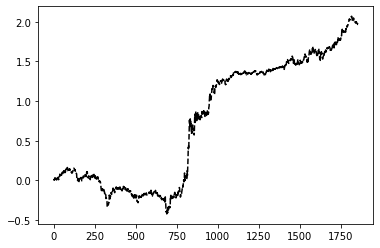

In [40]:
k1 = np.mean(sharpup[30:len(csv_data)-N-1])
k2 = np.std(sharpup[30:len(csv_data)-N-1])
sharpratio = (k1/k2)*np.sqrt(250)
profit = profit[30:]
import matplotlib.pyplot as plt
from numpy.random import randn
import math
plt.plot(profit, 'k--')
print(max(profit))
print(np.mean(profit))
print('Sharpratio:'+str(sharpratio))
huiche = 0
for i in range(len(profit)):
    for j in range(i,len(profit)):
        k = profit[i]-profit[j]
        if(k>=huiche):
            huiche = k
print(huiche)

In [33]:
huiche = 0
for i in range(len(profit)):
    for j in range(i,len(profit)):
        k = profit[i]-profit[j]
        if(k>=huiche):
            huiche = k

0.5854727860217734


In [8]:
huiche = np.zeros(np.square(len(csv_data)-N-1))
k = 0
for i in range(len(profit)):
    profit[i]=profit[i]+1
for i in range(len(profit)):
    for j in range(i,len(profit)):
        if profit[j]!=0:
            huiche[k] = 1-profit[i]/profit[j]
        k = k+1
print('最大回撤:'+str(max(huiche)))

最大回撤:0.6088665890203656


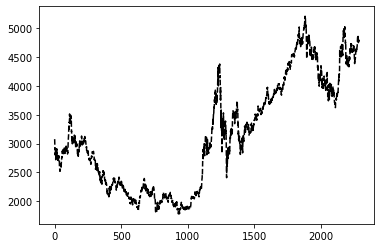

In [38]:
plt.plot(csv_data['CLOSE'], 'k--')